AUTHOR : ABIRAMI RAJALINGAM

I wrote all of the explanatory text and comments in this notebook. It was adapted from https://github.com/NitishKundu/Tweets_hate_speech_classification/blob/main/notebooks/hate_speech_detection_transfer_learning_model.ipynb

### Mounting google drive for final data

BLOCK 1

In [2]:
from google.colab import drive
# This imports the drive module from the google.colab library, which provides a set of tools for working with Google Drive in Colab.

drive.mount('/content/gdrive')
#This mounts the Google Drive of the user who is running the Colab notebook and prompts them to enter an authorization code to grant Colab access to their Drive
root_path = 'gdrive/My Drive/hate_speech/'
#This sets the root_path variable to the path of a specific directory in the user's Google Drive.

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Importing necessary libraries

BLOCK 2

In [3]:
import numpy as np
#numpy library is usually used for performing numerical computations and manipulating arrays
import pandas as pd
#panda library is used for data manipulation, analysis, and visualization
import tensorflow as tf
#the main library used for creating and training neural networks.
from tensorflow import keras
#the high-level API for building and training models in TensorFlow.
import tensorflow_hub as hub
#provides a way to easily use pre-trained models for transfer learning.
import matplotlib.pyplot as plt
#is a library for plotting graphs and charts.
from tensorflow.keras.optimizers import Adam
#adam is an optimizer from the keras API used for gradient descent during training.

#The above code imports the necessary libraries for implementing a neural network using TensorFlow, including NumPy, Pandas, TensorFlow, TensorFlow Hub, and Matplotlib. 
#It also imports the Adam optimizer from Keras.

### Reading data in CSV format

BLOCK 3

In [4]:
data =  pd.read_csv('gdrive/My Drive/hate_speech/final_data.csv')
#This uses the pd.read_csv() function from the pandas library to read a CSV file located at drive.
#the data is loaded into a DataFrame data
data.head()
##This displays the first few rows of the DataFrame.

,Unnamed: 0,tweet_lower,handle_count,handle_removed,url_removed,special_char_removed,single_hashtag_removed,tweets_length,lemmatized,tweet_stopwords_removed,target
0,0,brand new big flowdan in the emails #horrorshow,0,brand new big flowdan in the emails #horrorshow,brand new big flowdan in the emails #horrorshow,brand new big flowdan in the emails #horrorshow,brand new big flowdan in the emails #horrorshow,49,brand new big flowdan in the email #horrorshow,brand new big flowdan email #horrorshow,0
1,1,@mckinley719 fuck bitches get money,1,fuck bitches get money,fuck bitches get money,fuck bitches get money,fuck bitches get money,23,fuck bitch get money,fuck bitch get money,1
2,2,rt @_____al: exactly. don't be gettin no addit...,1,rt : exactly. don't be gettin no additional pu...,rt : exactly. don't be gettin no additional pu...,rt exactly don't be gettin no additional pu...,rt exactly don't be gettin no additional pu...,95,rt exactly do n't be gettin no additional puss...,exactly n't gettin additional pussy soft ass t...,1
3,3,niccas use to be like you always tryn pull a f...,0,niccas use to be like you always tryn pull a f...,niccas use to be like you always tryn pull a f...,niccas use to be like you always tryn pull a f...,niccas use to be like you always tryn pull a f...,77,niccas use to be like you always tryn pull a f...,niccas use like always tryn pull finesse duh n...,1
4,4,@munafal777 karma is a bitch,1,karma is a bitch,karma is a bitch,karma is a bitch,karma is a bitch,17,karma be a bitch,karma bitch,1


### Selecting only 2 columns that are important for model building

BLOCK 4

In [5]:
data = data[['tweet_stopwords_removed', 'target']]
#The code above selects only two columns from the original dataset 'data', 
#which are 'tweet_stopwords_removed' and 'target' and stores them as a new dataframe 'data'. 
#This is done to only keep the relevant data for the classification task.
data

,tweet_stopwords_removed,target
0,brand new big flowdan email #horrorshow,0
1,fuck bitch get money,1
2,exactly n't gettin additional pussy soft ass t...,1
3,niccas use like always tryn pull finesse duh n...,1
4,karma bitch,1
...,...,...
40211,dress ready,0
40212,many bitch get rabies hate hoppin' woman #stan...,1
40213,#lesmiserables gang ready westendlive #lesmise...,0
40214,dumb ugly stupid bullshit ass bitch,1


In [6]:
# dropping null values
data = data.dropna()
data.reset_index(inplace=True, drop=True)
data

#This code drops any rows with missing values in the data dataframe, resets the index of the remaining rows, and displays the resulting dataframe. 

,tweet_stopwords_removed,target
0,brand new big flowdan email #horrorshow,0
1,fuck bitch get money,1
2,exactly n't gettin additional pussy soft ass t...,1
3,niccas use like always tryn pull finesse duh n...,1
4,karma bitch,1
...,...,...
40175,dress ready,0
40176,many bitch get rabies hate hoppin' woman #stan...,1
40177,#lesmiserables gang ready westendlive #lesmise...,0
40178,dumb ugly stupid bullshit ass bitch,1


In [7]:
data.isna().sum()
#checking for any na values using isna() and sum() and the results are 0

tweet_stopwords_removed    0
target                     0
dtype: int64

In [8]:
print(len(data[data['target'] == 1]))
print(len(data[data['target'] == 0]))

#This code is printing the number of tweets in the dataset that are labeled as target 1 
# and target 0 respectively. 
#It is useful to check the class distribution of the dataset and ensure that there are a roughly equal number of examples in each class 
#to avoid bias in the model's predictions.

20603
19577


In [9]:
df = data.copy()
#copying the data dataframe into df dataframe
df

,tweet_stopwords_removed,target
0,brand new big flowdan email #horrorshow,0
1,fuck bitch get money,1
2,exactly n't gettin additional pussy soft ass t...,1
3,niccas use like always tryn pull finesse duh n...,1
4,karma bitch,1
...,...,...
40175,dress ready,0
40176,many bitch get rabies hate hoppin' woman #stan...,1
40177,#lesmiserables gang ready westendlive #lesmise...,0
40178,dumb ugly stupid bullshit ass bitch,1


## Splitting train, test, val datasets

BLOCK 5

In [10]:
train, val, test = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])
#This code is splitting the DataFrame df into three subsets: training set, validation set, and test set using the np.split function from NumPy.
#The sample function with frac=1 argument shuffles the rows of df randomly and returns the entire shuffled DataFrame. 
#The first split is at 80% of the total length of the shuffled DataFrame df, 
#the second split is at 90% of the total length of the shuffled DataFrame df, and the remaining rows become the test set.
#The resulting subsets are assigned to the variables train, val, and test, respectively.

In [11]:
print(len(train), 'training examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

#The code prints the number of examples in the training, validation, and test sets, respectively. 
#It is used to verify that the dataset has been split correctly into the three subsets.

32144 training examples
4018 validation examples
4018 test examples


### Preparing dataset for model

BLOCK 6

In [12]:
#This is a function definition for df_to_dataset that takes three parameters - 
#the input dataframe df, a boolean flag shuffle to indicate whether or not to shuffle the data, 
#and an integer batch_size to determine the batch size for the dataset.
def df_to_dataset(df, shuffle=True, batch_size=256):
  df = df.copy()
  labels = df.pop('target')
  df = df['tweet_stopwords_removed']
  #This makes a copy of the input dataframe and saves the target column as the labels. 
  #The df variable is then set to only include the tweet_stopwords_removed column.
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  #This creates a TensorFlow dataset from the input dataframe and the labels. 
  #The from_tensor_slices method creates a dataset with one element for each row in the input dataframe.
  if shuffle:
    ds = ds.shuffle(buffer_size=len(df))
    #If shuffle is True, this shuffles the dataset using the shuffle method and a buffer size of the length of the dataframe.
  ds = ds.batch(batch_size)
  #This batches the dataset using the batch method and the batch_size parameter.
  ds = ds.prefetch(tf.data.AUTOTUNE)
  #This uses the prefetch method to asynchronously fetch batches while the model is training to optimize performance.
  return ds

In [13]:
train_data= df_to_dataset(train)
#train_data variable is assigned the result of calling the df_to_dataset() function with the train DataFrame as an argument, 
#which converts the DataFrame into a TensorFlow dataset with inputs as tweet_stopwords_removed and output as target and sets some additional parameters 
#like shuffle and batch_size.
val_data= df_to_dataset(val)
#val_data variable is assigned the result of calling the df_to_dataset() function with the val DataFrame as an argument, 
#which converts the DataFrame into a TensorFlow dataset with inputs as tweet_stopwords_removed and output as target and sets some additional parameters 
#like shuffle and batch_size.
test_data= df_to_dataset(test)
#test_data: This variable is assigned the result of calling the df_to_dataset() function with the test DataFrame as an argument, 
#which converts the DataFrame into a TensorFlow dataset with inputs as tweet_stopwords_removed and output as target and sets some additional parameters 
#like shuffle and batch_size.

In [14]:
list(train_data)[0]
#This code outputs the first batch of data from the train_data dataset

(<tf.Tensor: shape=(256,), dtype=string, numpy=
 array([b'#juicing experience #notsobad #healthyliving #eatclean #fitness #cook #yummy #mamasgotanewtoy',
        b'figure #riggedprimary',
        b'powerful share guilt alive patience caer survivor #orlandoshooting',
        b'#womenwhofarm #farmbitch harvest', b"i'm vipperloid bitch",
        b'hope address attempt contain nutty conspiracy gaslighting suppoers',
        b'youzza bitch',
        b'female constantly tweet boyfriend wish death one tire bitch',
        b'one jump conversation smelly ass bitch fuck thats',
        b'beautiful girl world #brunomars', b'miss faggot',
        b'clip last night look sound great look forward show birmingham saturday',
        b"inside i'm #jumpingjacks book another #voiceover yay super",
        b'datsyuk always favorite red wing man one year #goingtomisshim',
        b'check #simple #tip #life #happiness #happinesseverywhere #happinessequation #lifestyle',
        b'bobby bitch bobby bitch',
  

## Using nnlm-en-dim50 model

Token based text embedding trained on English Google News 7B corpus.




BLOCK 6

In [15]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)

#embedding is a URL string that points to a pre-trained embedding model hosted on TensorFlow Hub. 
#In this case, it is the NNLM (Neural Network Language Model) model trained on English text with 50 dimensions.

#hub_layer is a KerasLayer that loads the pre-trained embedding model from the URL string specified in embedding. 
#It specifies the input data type as tf.string, which is the data type of the text data, 
#and sets trainable as True to fine-tune the weights of the pre-trained model during training. 
#This layer can be added to a Keras model as the first layer to take in text data as input and output the corresponding embeddings.

In [16]:
hub_layer(list(train_data)[0][0])
#This code applies the hub_layer created in the previous code block to the first batch of the training data (list(train_data)[0][0]), 
#which is a tuple containing the input tweet texts and their corresponding labels.

<tf.Tensor: shape=(256, 50), dtype=float32, numpy=
array([[ 0.45978546, -0.20010242, -0.24247447, ..., -0.2758971 ,
         0.04271352,  0.15172802],
       [ 0.13726735,  0.0221791 , -0.4439584 , ..., -0.07071715,
         0.18375547,  0.22941239],
       [ 0.10884704, -0.43065596, -0.43730292, ..., -0.00654227,
        -0.06117399, -0.00715901],
       ...,
       [ 0.5029083 , -0.01390251,  0.24099869, ..., -0.19234806,
         0.04353707,  0.15428233],
       [ 0.33913505, -0.05714668,  0.2973249 , ..., -0.0327189 ,
        -0.30339026,  0.15871252],
       [ 0.24893029, -0.06847649, -0.2505254 , ..., -0.1272309 ,
         0.20204635, -0.06366417]], dtype=float32)>

## Final Model for hate speech classification

BLOCK 7

In [17]:
# model architecture
#This code creates a neural network model with the following architecture:
model = tf.keras.Sequential()
model.add(hub_layer)
#The first layer is a pre-trained Keras layer that maps text inputs to 50-dimensional embeddings, obtained from the "nnlm-en-dim50" module from TensorFlow Hub.
model.add(tf.keras.layers.Dense(256, activation='relu'))
#The next layer is a dense layer with 256 units and ReLU activation.
model.add(tf.keras.layers.Dropout(0.5))
#A dropout layer is added after the dense layer to regularize the network and prevent overfitting. The dropout rate is set to 0.5.
model.add(tf.keras.layers.Dense(128, activation='relu'))
#Another dense layer is added with 128 units and ReLU activation.
model.add(tf.keras.layers.Dropout(0.2))
#Another dropout layer is added with a dropout rate of 0.2.
model.add(tf.keras.layers.Dense(32, activation='relu'))
#A third dense layer is added with 32 units and ReLU activation.
model.add(tf.keras.layers.Dropout(0.4))
#A fourth dropout layer is added with a dropout rate of 0.4.
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
#The final output layer is a dense layer with 1 unit and sigmoid activation, used to produce binary classification output.

In [18]:
# defining callback for on epoch end
#A mycallback class is defined which is a subclass of tf.keras.callbacks.Callback.
class mycallback(tf.keras.callbacks.Callback):
  #on_epoch_end method is defined which will be called at the end of each epoch.
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') > 0.997 and logs.get('val_accuracy') > 0.975:
      #The logs parameter is used to get the values of accuracy and validation accuracy at the end of each epoch.
      print('\n\n\nTraining Stopped. Accuracy reached 99.7% and Validation accuracy reached 97.5%\n\n')
      #If the accuracy of the model on training data is greater than 0.997 and the validation accuracy is greater than 0.975, then it will print a message and stop training the model.
      self.model.stop_training = True
      #An instance of mycallback class is created and assigned to the variable callback.
callback = mycallback()

BLOCK 8

In [19]:
# compiling model

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              #model.compile() function is used to configure the model for training.
              #optimizer parameter specifies the optimization algorithm used to minimize the loss 
              #function. Here, Adam optimization algorithm is used with a learning rate of 0.001.
              loss=tf.keras.losses.BinaryCrossentropy(),
              #loss parameter specifies the loss function to be minimized during training. 
              #Here, Binary Cross-Entropy loss function is used because it is suitable for binary classification problems.
              metrics=["accuracy"])
              #metrics parameter specifies the evaluation metrics to be used to monitor the training and testing steps. Here, accuracy is used as the evaluation metric.

In [20]:
# testing untrained model on train data for accuracy

model.evaluate(train_data)

126/126 [==============================] - 7s 4ms/step - loss: 0.7000 - accuracy: 0.4050


[0.6999505758285522, 0.40502116084098816]

In [21]:
# testing untrained model on validation data for accuracy

model.evaluate(val_data)

16/16 [==============================] - 0s 4ms/step - loss: 0.7003 - accuracy: 0.3982


[0.7002557516098022, 0.39820805191993713]

In [22]:
# training model for 10 epoch but with defined callback

history = model.fit(train_data, epochs=100, validation_data=val_data, callbacks=callback)

Epoch 1/100
126/126 [==============================] - 24s 161ms/step - loss: 0.2487 - accuracy: 0.9016 - val_loss: 0.0901 - val_accuracy: 0.9657
Epoch 2/100
126/126 [==============================] - 11s 89ms/step - loss: 0.0697 - accuracy: 0.9800 - val_loss: 0.0625 - val_accuracy: 0.9806
Epoch 3/100
126/126 [==============================] - 7s 52ms/step - loss: 0.0371 - accuracy: 0.9909 - val_loss: 0.0613 - val_accuracy: 0.9811
Epoch 4/100
126/126 [==============================] - 8s 61ms/step - loss: 0.0233 - accuracy: 0.9952 - val_loss: 0.0677 - val_accuracy: 0.9813
Epoch 5/100
126/126 [==============================] - 4s 33ms/step - loss: 0.0166 - accuracy: 0.9965 - val_loss: 0.0783 - val_accuracy: 0.9798
Epoch 6/100
126/126 [==============================] - ETA: 0s - loss: 0.0137 - accuracy: 0.9974


Training Stopped. Accuracy reached 99.7% and Validation accuracy reached 97.5%


126/126 [==============================] - 4s 31ms/step - loss: 0.0137 - accuracy: 0.9974 - val_l

In [23]:
# testing trained model on test data for accuracy

accuracy = model.evaluate(test_data)[1]

print(f'\nThe accuracy of trained model on test data is : {round((accuracy)*100,2)} %')

16/16 [==============================] - 0s 8ms/step - loss: 0.1227 - accuracy: 0.9741

The accuracy of trained model on test data is : 97.41 %


### Plotting Accuracy and loss curve

BLOCK 9

In [24]:
#This code defines the training history of the neural network model.

acc = history.history['accuracy']
#A list of accuracy values of the model during training on the training set.
val_acc = history.history['val_accuracy']
#A list of accuracy values of the model during training on the validation set.
loss = history.history['loss']
#A list of loss values of the model during training on the training set.
val_loss = history.history['val_loss']
# A list of loss values of the model during training on the validation set.

epochs = range(1, len(acc) + 1)
#The number of epochs for which the model was trained, ranging from 1 to the length of the acc list.

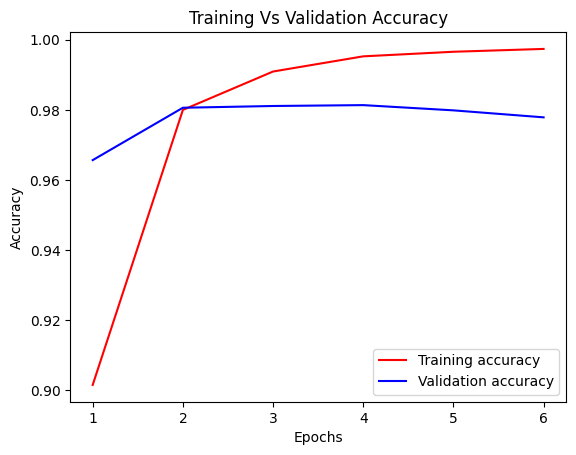

In [25]:
# Taining accuracy Vs Validation accuracy

# "r" is for "solid red line"
plt.plot(epochs, acc, 'r', label='Training accuracy')
# b is for "solid blue line"
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training Vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

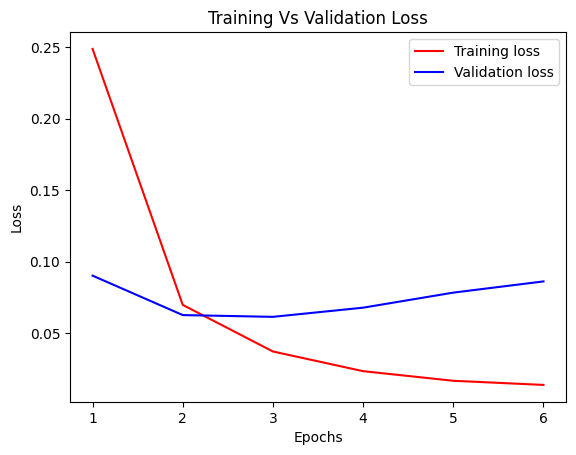

In [26]:
# Taining loss Vs Validation loss

# "r" is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training Vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()